In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os
import copy

sys.path.append(os.path.abspath('../'))

import utils.ml_util
importlib.reload(utils.ml_util)
from utils.ml_util import *

import utils.trading_util
importlib.reload(utils.trading_util)
from utils.trading_util import *

In [10]:
TKR = 'T'
MAX_HOLDING = 100
START_DATE = pd.Timestamp('1999-01-01')
END_DATE = pd.Timestamp('2010-01-01')
TIME_EFFECT = 3
BLUR_KERNAL_SIZE = 3

historic_prices = yf.download(TKR)['Adj Close']
training_prices = [float(x) for x in historic_prices[TKR][START_DATE:END_DATE]]

[*********************100%***********************]  1 of 1 completed


Outlook is a function of future returns, weighted less as time progresses

In [11]:
outlook = []
for pos1 in range(len(training_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (training_prices[pos1 + pos2] - training_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(ans / integrated_time_effect[TIME_EFFECT])
    
n_outlook = normalize_average(outlook, MAX_HOLDING * 3)
bn_outlook = gaussian_blur(n_outlook, BLUR_KERNAL_SIZE)

Text(0, 0.5, 'Blurred Normalized Outlook')

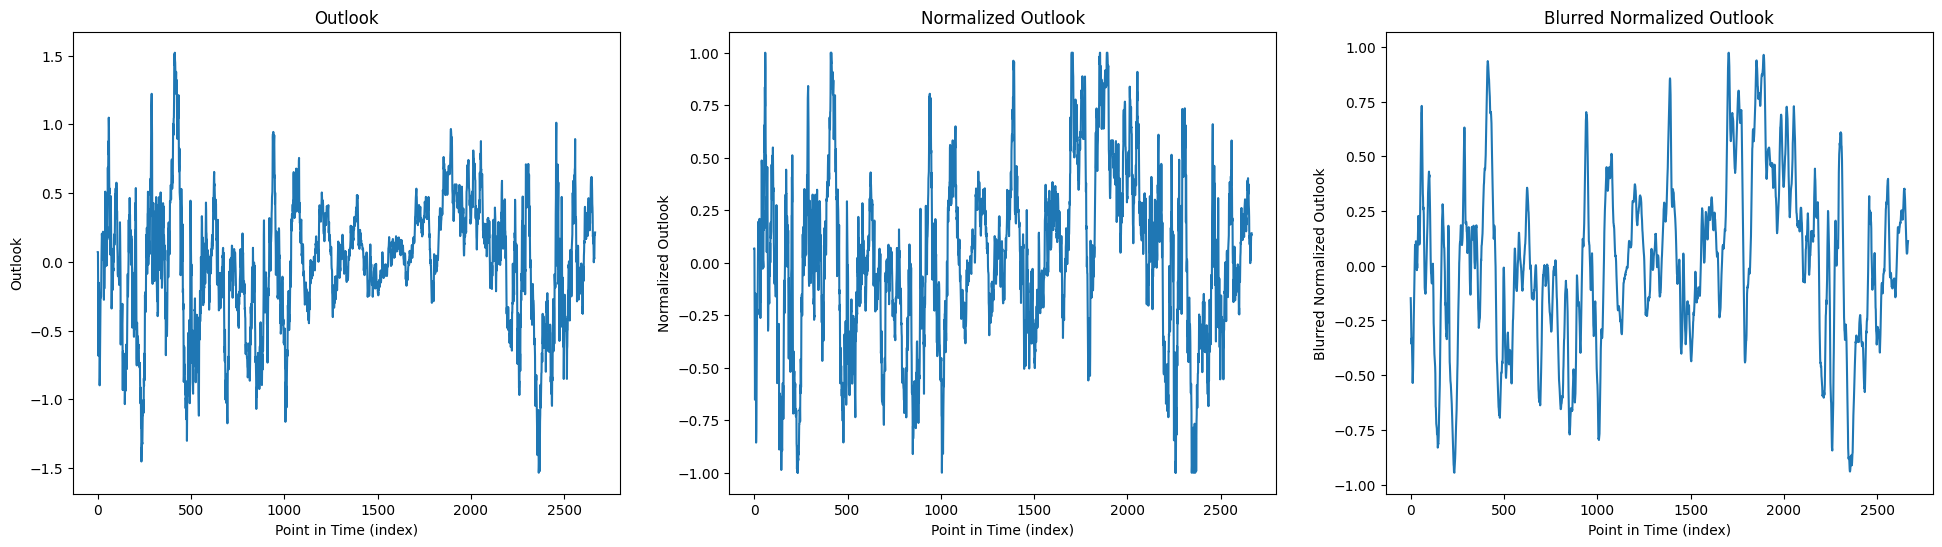

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

ax1.plot(range(len(outlook)), outlook)
ax1.set_title('Outlook')
ax1.set_xlabel('Point in Time (index)')
ax1.set_ylabel('Outlook')

ax2.plot(range(len(n_outlook)), n_outlook)
ax2.set_title('Normalized Outlook')
ax2.set_xlabel('Point in Time (index)')
ax2.set_ylabel('Normalized Outlook')

ax3.plot(range(len(bn_outlook)), bn_outlook)
ax3.set_title('Blurred Normalized Outlook')
ax3.set_xlabel('Point in Time (index)')
ax3.set_ylabel('Blurred Normalized Outlook')

In [13]:
sell_time = []
for day in range(len(training_prices) - MAX_HOLDING):
    if n_outlook[day] > 0:
        highest = 0
        highest_pos = 0
        for delay in range(MAX_HOLDING):
            delta = (training_prices[day + delay] - training_prices[day]) * time_effect[TIME_EFFECT](MAX_HOLDING, delay)
            if delta > highest:
                highest = delta
                highest_pos = delay
        sell_time.append(highest_pos / MAX_HOLDING)
    else:
        lowest = 0
        lowest_pos = 0
        for delay in range(MAX_HOLDING):
            delta = (training_prices[day + delay] - training_prices[day]) * time_effect[TIME_EFFECT](MAX_HOLDING, delay)
            if delta < lowest:
                lowest = delta
                lowest_pos = delay
        sell_time.append(lowest_pos / MAX_HOLDING)
b_sell_time = gaussian_blur(sell_time, BLUR_KERNAL_SIZE)


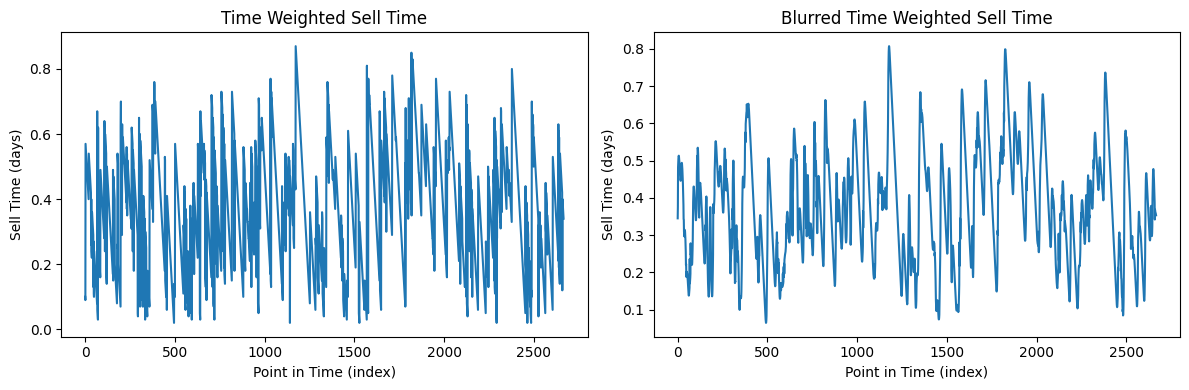

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(range(len(sell_time)), sell_time, label='Time Weighted')
axs[0].set_title('Time Weighted Sell Time')
axs[0].set_xlabel('Point in Time (index)')
axs[0].set_ylabel('Sell Time (days)')

axs[1].plot(range(len(b_sell_time)), b_sell_time, label='Blurred Time Weighted')
axs[1].set_title('Blurred Time Weighted Sell Time')
axs[1].set_xlabel('Point in Time (index)')
axs[1].set_ylabel('Sell Time (days)')

plt.tight_layout()
plt.show()

In [15]:
account = Account()
testing_prices = training_prices[:len(bn_outlook)]
stock = Stock(TKR, testing_prices[0])
MAX_TRANSACTION = 1

sell_orders = {}
cover_orders = {}

buy_positions = []
sell_positions = []
executed_sell_orders = []
executed_cover_orders = []

net_worth = []
min_balance = 0

for pos in range(len(testing_prices)):
    stock.update_price(testing_prices[pos])
    
    if bn_outlook[pos] > 0.25:
        account.buy(stock, abs(MAX_TRANSACTION * n_outlook[pos]))
        sell_orders[int(pos + (sell_time[pos] * MAX_HOLDING))] = abs(MAX_TRANSACTION * n_outlook[pos])
        buy_positions.append((pos, testing_prices[pos]))
    elif bn_outlook[pos] < -0.25:
        account.sell(stock, abs(MAX_TRANSACTION * bn_outlook[pos]))
        cover_orders[int(pos + (sell_time[pos] * MAX_HOLDING))] = abs(MAX_TRANSACTION * n_outlook[pos])
        sell_positions.append((pos, testing_prices[pos]))
    
    if pos in sell_orders:
        account.sell(stock, sell_orders[pos])
        executed_sell_orders.append((pos, testing_prices[pos]))
    if pos in cover_orders:
        account.buy(stock, cover_orders[pos])
        executed_cover_orders.append((pos, testing_prices[pos]))

    net_worth.append(account.net_worth())
    if account.balance < min_balance:
        min_balance = account.balance

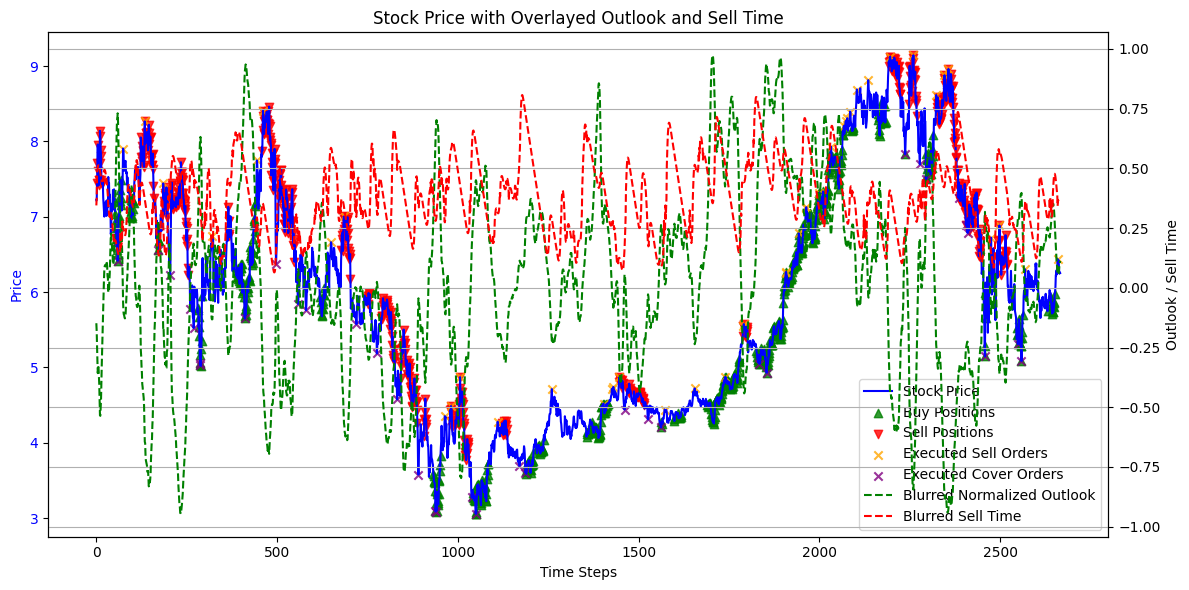

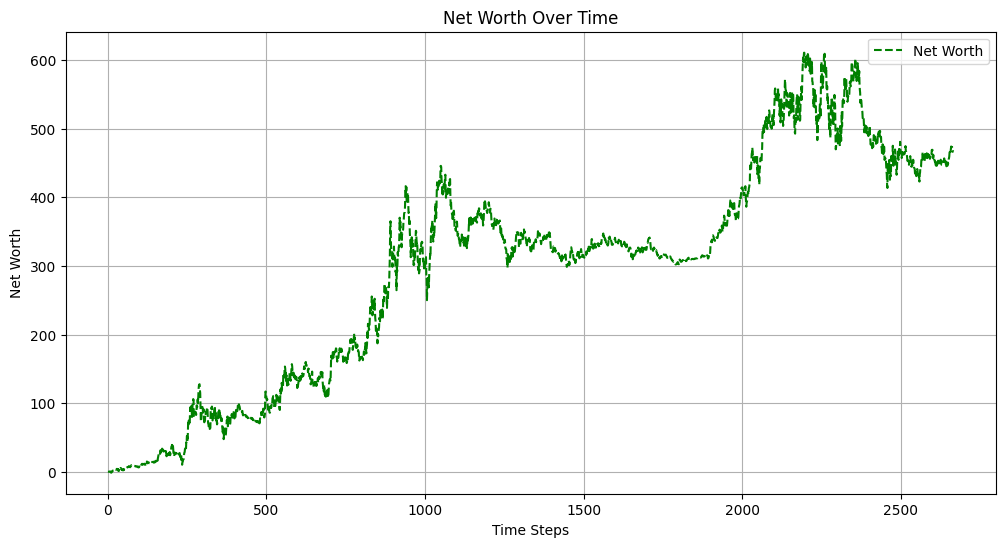

Balance: $217.96
Net Worth: $466.76
Total Profit: 109.53%
Holdings:
T: 39.791909003421054 shares
Stock Profit: -13.38%


In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(testing_prices)), testing_prices, label="Stock Price", color="blue")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

buy_x, buy_y = zip(*buy_positions) if buy_positions else ([], [])
ax1.scatter(buy_x, buy_y, label="Buy Positions", color="green", marker="^", alpha=0.8)

sell_x, sell_y = zip(*sell_positions) if sell_positions else ([], [])
ax1.scatter(sell_x, sell_y, label="Sell Positions", color="red", marker="v", alpha=0.8)

exec_sell_x, exec_sell_y = zip(*executed_sell_orders) if executed_sell_orders else ([], [])
ax1.scatter(exec_sell_x, exec_sell_y, label="Executed Sell Orders", color="orange", marker="x", alpha=0.8)

exec_cover_x, exec_cover_y = zip(*executed_cover_orders) if executed_cover_orders else ([], [])
ax1.scatter(exec_cover_x, exec_cover_y, label="Executed Cover Orders", color="purple", marker="x", alpha=0.8)

ax2 = ax1.twinx()
ax2.plot(range(len(outlook)), bn_outlook, label="Blurred Normalized Outlook", color="green", linestyle="--")
ax2.plot(range(len(sell_time)), b_sell_time, label="Blurred Sell Time", color="red", linestyle="--")
ax2.set_ylabel("Outlook / Sell Time", color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.title("Stock Price with Overlayed Outlook and Sell Time")
plt.grid()
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(net_worth)), net_worth, label="Net Worth", color="green", linestyle="--")

plt.title("Net Worth Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.grid()

plt.show()

print(account)
print(f"Stock Profit: {(testing_prices[-1] - testing_prices[0]) / testing_prices[0] * 100:.2f}%")